In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import xgboost
import lightgbm
import catboost
import sklearn.svm

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
data = pd.read_excel('.\data_2_samples_NEW.xlsx', index_col=0)

In [4]:
data.head()

,gender,age,bmi,ao,activity,male_heredity,smoking,AGT_AGTR2,stage_agr,sample
0,0,0,0,0,0,1,0,0,1,0
1,1,1,0,0,1,0,1,0,1,0
2,1,1,0,1,1,0,1,0,1,0
3,1,0,1,1,1,0,0,1,1,0
4,0,1,1,1,0,0,0,0,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 0 to 787
Data columns (total 10 columns):
gender           788 non-null int64
age              788 non-null int64
bmi              788 non-null int64
ao               788 non-null int64
activity         788 non-null int64
male_heredity    788 non-null int64
smoking          788 non-null int64
AGT_AGTR2        788 non-null int64
stage_agr        788 non-null int64
sample           788 non-null int64
dtypes: int64(10)
memory usage: 67.7 KB


In [6]:
X = data.drop('stage_agr', axis=1)
y = data['stage_agr']

In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.33,
                                     random_state=42, stratify=y)

In [8]:
X_sample_0 = data.query('sample == 0').drop(['stage_agr', 'sample'], axis=1)
y_sample_0 = data.query('sample == 0')['stage_agr']

X_sample_1 = data.query('sample == 1').drop(['stage_agr', 'sample'], axis=1)
y_sample_1 = data.query('sample == 1')['stage_agr']

In [9]:
(X_sample_0_train, X_sample_0_test,
 y_sample_0_train, y_sample_0_test) = train_test_split(X_sample_0, y_sample_0, 
                                                       test_size=0.33, stratify=y_sample_0,
                                                       random_state=42)

In [10]:
X_train

,gender,age,bmi,ao,activity,male_heredity,smoking,AGT_AGTR2,sample
79,0,1,1,1,0,0,0,0,0
317,1,0,0,0,0,0,0,1,0
81,0,0,0,1,1,0,1,0,0
119,1,1,0,0,0,0,1,1,0
184,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
330,0,1,1,1,1,0,0,0,0
398,0,1,1,1,0,0,0,0,0
377,0,0,0,0,1,0,0,0,0
484,0,1,1,1,1,0,0,0,0


In [11]:
y_test.value_counts()

1    177
0     84
Name: stage_agr, dtype: int64

In [12]:
def plot_for_treshhold(cls, y, y_prob):
    x1 = np.linspace(0.1, 0.9, 100)
    y1 = []
    y2 = []
    y3 = []
    for th in x1:
        y_pred = list(map(lambda x: 1 if x > th else 0, y_prob))
        y1.append(metrics.roc_auc_score(y, y_prob))
        y2.append(metrics.accuracy_score(y, y_pred))
        y3.append(metrics.recall_score(y, y_pred))
    
    print(x1[np.argmax(y2)])
#    print(max)
    plt.figure(figsize=(12, 10))
    plt.plot(x1, y1, label='roc')
    plt.plot(x1, y2, label='acc')
    plt.plot(x1, y3, label='req')
    plt.legend()
    plt.show()

In [13]:
def use_classificator(cls, X_train, X_test, y_train, y_test,
                      threeshold=0.5, choose_th=False):
    cls.fit(X_train, y_train)
    y_prob = cls.predict_proba(X_test)[:, 1]
    y_pred = list(map(lambda x: 1 if x > threeshold else 0, y_prob))
    
    roc_train = metrics.roc_auc_score(y_train, cls.predict_proba(X_train)[:, 1])
    roc_test = metrics.roc_auc_score(y_test, y_prob)
    acc = metrics.accuracy_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    
    print(f'ROC-AUC score TRAIN: {roc_train:.2}')
    print(f'ROC-AUC score TEST: {roc_test:.2}')
    print(f'Accuracy score: {acc:.2}')
    print(f'Recall score: {rec:.2}')
    
    if choose_th:
        plot_for_treshhold(cls, y_test, y_prob)
    
    return cls

# Без генетических

In [569]:
data.head()

,gender,age,bmi,ao,activity,male_heredity,smoking,AGT_AGTR2,stage_agr,sample
0,0,0,0,0,0,1,0,0,1,0
1,1,1,0,0,1,0,1,0,1,0
2,1,1,0,1,1,0,1,0,1,0
3,1,0,1,1,1,0,0,1,1,0
4,0,1,1,1,0,0,0,0,1,0


## Log-reg

In [14]:
lg_reg_1 = LogisticRegression(class_weight={0: 1, 1: 4},
                           solver='liblinear', C=0.123)

In [15]:
use_classificator(lg_reg_1, X_train.drop('AGT_AGTR2', axis=1),
                  X_test.drop('AGT_AGTR2', axis=1), y_train,
                  y_test, threeshold=0.77)

ROC-AUC score TRAIN: 0.79
ROC-AUC score TEST: 0.78
Accuracy score: 0.75
Recall score: 0.94


LogisticRegression(C=0.123, class_weight={0: 1, 1: 4}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Tree

In [87]:
d_tree = DecisionTreeClassifier(max_depth=5, class_weight={0:1, 1:3},
                                random_state=42)

In [89]:
use_classificator(d_tree, X_train.drop('AGT_AGTR2', axis=1),
                  X_test.drop('AGT_AGTR2', axis=1), y_train,
                  y_test, threeshold=0.7)

ROC-AUC score TRAIN: 0.82
ROC-AUC score TEST: 0.8
Accuracy score: 0.75
Recall score: 0.93


DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

## KNN

In [123]:
knn = KNeighborsClassifier(n_neighbors=17)

In [126]:
use_classificator(knn,X_train.drop('AGT_AGTR2', axis=1),
                  X_test.drop('AGT_AGTR2', axis=1), y_train,
                  y_test, threeshold=0.47)

ROC-AUC score TRAIN: 0.81
ROC-AUC score TEST: 0.8
Accuracy score: 0.77
Recall score: 0.93


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

# С генетическими

## Log-reg

In [215]:
lg_reg_2 = LogisticRegression(class_weight={0:1, 1:2}, max_iter=200)

In [216]:
use_classificator(lg_reg_2, X_train,
                  X_test, y_train,
                  y_test, threeshold=0.6)

ROC-AUC score TRAIN: 0.79
ROC-AUC score TEST: 0.78
Accuracy score: 0.74
Recall score: 0.93


LogisticRegression(C=1.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## LDA

In [171]:
lda = LinearDiscriminantAnalysis()

In [173]:
use_classificator(lda, X_train,
                  X_test, y_train,
                  y_test, threeshold=0.42)

ROC-AUC score TRAIN: 0.79
ROC-AUC score TEST: 0.78
Accuracy score: 0.75
Recall score: 0.94


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

## Bernuli NB

In [579]:
g_nb = BernoulliNB()

In [581]:
use_classificator(g_nb, X_train,
                  X_test, y_train,
                  y_test, threeshold=0.32)

ROC-AUC score TRAIN: 0.79
ROC-AUC score TEST: 0.76
Accuracy score: 0.74
Recall score: 0.93


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Random Forest

In [294]:
rf = RandomForestClassifier(random_state=42,
                            max_depth=2,
                            class_weight={0:1, 1:3})

In [585]:
use_classificator(rf, X_train,
                      X_test, y_train,
                      y_test, threeshold=0.75)

ROC-AUC score TRAIN: 0.78
ROC-AUC score TEST: 0.77
Accuracy score: 0.74
Recall score: 0.98


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

## Desision tree

In [364]:
dt = DecisionTreeClassifier(max_depth=9, max_features=6,
                            min_samples_leaf=7, random_state=42)

In [587]:
use_classificator(dt, X_train,
                      X_test, y_train,
                      y_test,  threeshold=0.5)

ROC-AUC score TRAIN: 0.82
ROC-AUC score TEST: 0.78
Accuracy score: 0.76
Recall score: 0.86


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

## XGBoost

In [420]:
xgb = xgboost.XGBClassifier(n_estimators=120, random_state=42)

In [590]:
use_classificator(xgb, X_train,
                      X_test, y_train,
                      y_test, threeshold=0.5)

ROC-AUC score TRAIN: 0.85
ROC-AUC score TEST: 0.8
Accuracy score: 0.77
Recall score: 0.89


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## LightGBM

In [467]:
lgbm = lightgbm.LGBMClassifier(random_state=42, max_depth=8)

In [592]:
use_classificator(lgbm, X_train,
                      X_test, y_train,
                      y_test, threeshold=0.5)

ROC-AUC score TRAIN: 0.86
ROC-AUC score TEST: 0.8
Accuracy score: 0.76
Recall score: 0.85


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Catboost

In [476]:
ctbst = catboost.CatBoostClassifier()

In [593]:
use_classificator(ctbst, X_train,
                      X_test, y_train,
                      y_test, threeshold=0.5)

Learning rate set to 0.013976
0:	learn: 0.6880966	total: 41.1ms	remaining: 41s
1:	learn: 0.6825814	total: 79.8ms	remaining: 39.8s
2:	learn: 0.6777155	total: 101ms	remaining: 33.5s
3:	learn: 0.6729402	total: 132ms	remaining: 32.8s
4:	learn: 0.6684906	total: 156ms	remaining: 31.1s
5:	learn: 0.6640578	total: 178ms	remaining: 29.5s
6:	learn: 0.6585821	total: 215ms	remaining: 30.5s
7:	learn: 0.6534932	total: 252ms	remaining: 31.2s
8:	learn: 0.6503100	total: 273ms	remaining: 30.1s
9:	learn: 0.6466467	total: 294ms	remaining: 29.1s
10:	learn: 0.6424023	total: 325ms	remaining: 29.2s
11:	learn: 0.6383188	total: 350ms	remaining: 28.8s
12:	learn: 0.6356076	total: 367ms	remaining: 27.9s
13:	learn: 0.6329106	total: 391ms	remaining: 27.5s
14:	learn: 0.6291893	total: 421ms	remaining: 27.6s
15:	learn: 0.6251644	total: 458ms	remaining: 28.2s
16:	learn: 0.6223351	total: 481ms	remaining: 27.8s
17:	learn: 0.6192859	total: 507ms	remaining: 27.7s
18:	learn: 0.6166492	total: 527ms	remaining: 27.2s
19:	learn: 

## SVM

In [511]:
svm = sklearn.svm.SVC(kernel='poly', degree=4, 
                      probability=True, random_state=42)

In [594]:
use_classificator(svm, X_train,
                      X_test, y_train,
                      y_test, threeshold=0.5)

ROC-AUC score TRAIN: 0.83
ROC-AUC score TEST: 0.81
Accuracy score: 0.77
Recall score: 0.91


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

# Feature impotance

In [567]:
lst_zip = list(zip(ctbst.feature_names_, ctbst.feature_importances_))
lst_zip = sorted(lst_zip, key=lambda tup: tup[1], reverse=True)

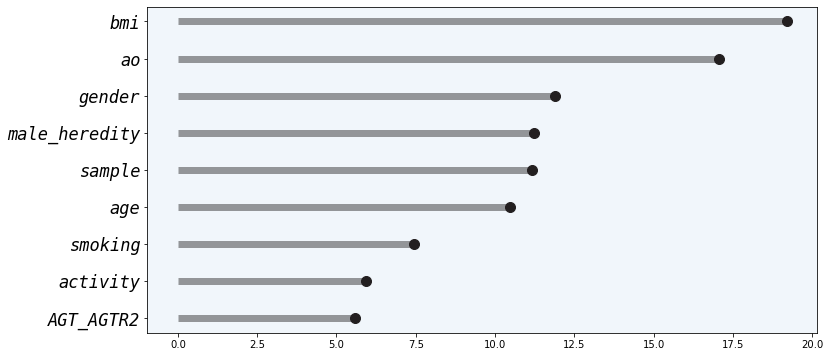

In [565]:
impot_features = []
for tup in lst_zip:
    impot_features.append(tup[0])
impot_features.reverse()
impot_features

plt.figure(figsize=(12, 6))

# Reorder it following the values:
my_range=range(1,10)

# Vertical version.
plt.hlines(y=my_range, xmin=0, xmax=sorted(ctbst.feature_importances_),
           color='#939598', linewidth=7.0)
plt.plot(sorted(ctbst.feature_importances_),
         my_range, "o", ms=10, color='#231F20')
ax = plt.gca()
plt.yticks(my_range, impot_features, fontstyle='italic',
           fontsize=17, fontfamily='monospace')
ax.set_facecolor('#F1F6FB')
plt.show()

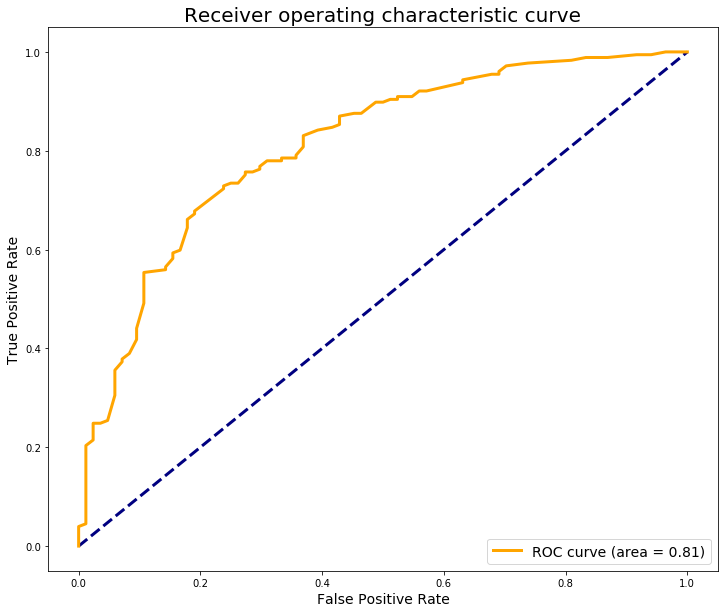

In [628]:
y_prob = svm.predict_proba(X_test)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, y_prob)
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob)

plt.figure(figsize=(12, 10))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=3)
plt.plot(fpr, tpr, color='orange', lw=3,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.show()